In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
### Question 1
# Canny Edge Detection

image_path = './cropped.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image)

[[230 232 233 233 234]
 [213 216 217 220 223]
 [159 163 166 169 173]
 [123 124 125 127 129]
 [122 121 122 122 122]]


In [4]:
# Gaussian Blur
def gkernel(size=3, sig=2):

    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

guassian_blur = gkernel(3,1)

#Image padding and gaussian smooth 
image_padded = np.full((7, 7), np.zeros(7), dtype=np.float32)
image_padded[1:6, 1:6] = image

blurred = cv2.filter2D(image, -1, guassian_blur)
blurred_padded = np.full((7, 7), np.zeros(7), dtype=np.float32)
blurred_padded[1:6, 1:6] = blurred


#Sobel Filter
#sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
sobel_x = cv2.Sobel(blurred_padded,cv2.CV_64F,1,0,ksize=3)

#grad_x = np.array(cv2.filter2D(blurred_padded, -1, sobel_x), dtype=np.float32)

#sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
sobel_y = cv2.Sobel(blurred_padded,cv2.CV_64F,0,1,ksize=3)
#grad_y = np.array(cv2.filter2D(blurred_padded, -1, sobel_y), dtype=np.float32)

print(sobel_x)

[[   0.  446.    4.    6.    6. -452.    0.]
 [   0.  651.    7.   11.    9. -662.    0.]
 [   0.  800.   11.   18.   13. -818.    0.]
 [   0.  673.   11.   18.   14. -691.    0.]
 [   0.  558.    8.   13.   11. -571.    0.]
 [   0.  380.    4.    7.    5. -387.    0.]
 [   0.  246.    2.    4.    2. -250.    0.]]


In [64]:


# Compute gradient magnitude and direction
gradient_magnitude = np.sqrt(grad_x[1:6, 1:6]**2 + grad_y[1:6, 1:6]**2)
gradient_direction = np.arctan2(grad_y[1:6, 1:6], grad_x[1:6, 1:6]) * (180/np.pi)
print(gradient_direction)
print()
print(gradient_magnitude)


[[ -43.371178  -89.51268   -89.24162   -89.38541  -136.32811 ]
 [  11.859779   87.17604    85.32258    86.57163   168.79787 ]
 [  17.716866   87.80507    86.44827    87.25504   162.41493 ]
 [  13.114545   87.397446   85.89189    86.63354   165.94014 ]
 [  46.4688     89.572426   89.25869    89.47629   133.13855 ]]

[[895.559   823.0298  831.0728  839.0483  915.24207]
 [817.4497  223.27113 220.73514 217.38905 833.88727]
 [706.5083  287.21072 290.55807 292.33542 724.8738 ]
 [572.9433  176.18172 181.46625 187.32326 588.63403]
 [551.72455 536.01495 541.0453  547.0228  565.9841 ]]


In [66]:
# Non-maximum suppression
edges = np.zeros_like(image)
M = image.shape[0]
N = image.shape[1]

for i in range(1, M-1): # i = 2
    for j in range(1, N-1): # j = 0
        try:
            q = 0
            r = 0
            
            # Get gradient magnitudes for neighboring pixels based on gradient direction
            if (0 <= gradient_direction[i, j] < 22.5) or (157.5 <= gradient_direction[i, j] <= 180):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (22.5 <= gradient_direction[i, j] < 67.5):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (67.5 <= gradient_direction[i, j] < 112.5):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            elif (112.5 <= gradient_direction[i, j] < 157.5):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            # Perform non-maximum suppression
            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                edges[i, j] = gradient_magnitude[i, j]
            else:
                edges[i, j] = 0
        except IndexError as e:
            pass




[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0 255 255 255   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


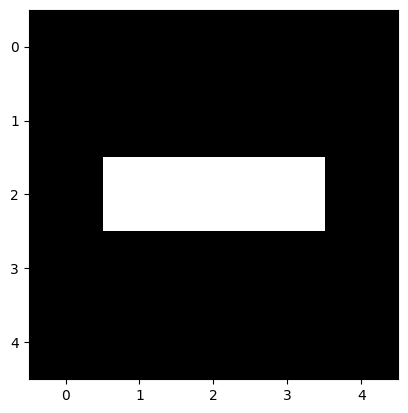

In [68]:
 # Apply double thresholding
high_threshold = 0.7 * np.max(edges)
low_threshold = 0.3 * np.max(edges)
strong_edges = (edges > high_threshold)
weak_edges = (edges > low_threshold) & (edges <= high_threshold)

# Thresholding
edges[edges < low_threshold] = 0
edges[edges >= high_threshold] = 255

print(edges)

plt.imshow(edges, cmap = 'gray')

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [255 255 255 255 255]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


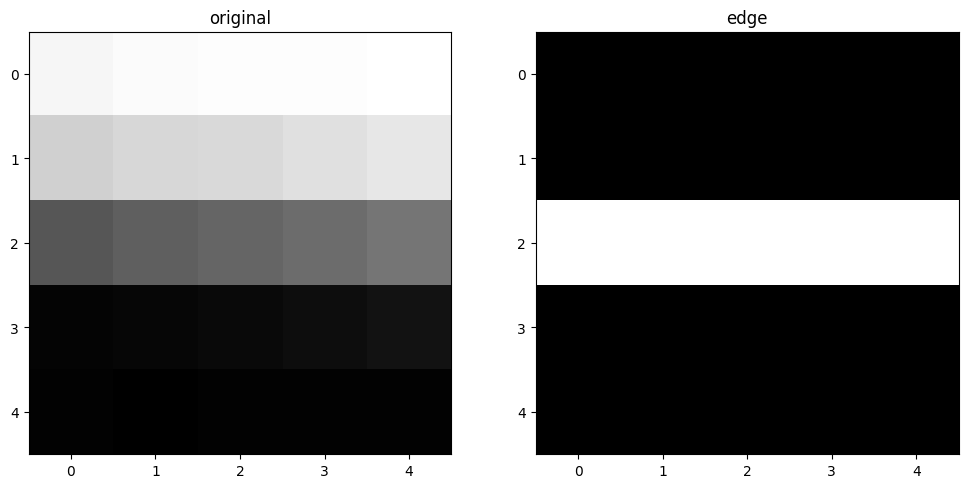

In [61]:
t_lower = 50  # Lower Threshold 
t_upper = 150  # Upper threshold 
  
# Applying the Canny Edge filter 
edge = cv2.Canny(image, t_lower, t_upper) 

print(edge)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(image, cmap='gray') 
plt.subplot(1, 2, 2)
plt.title('edge')
plt.imshow(edge, cmap='gray') 

[[1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]


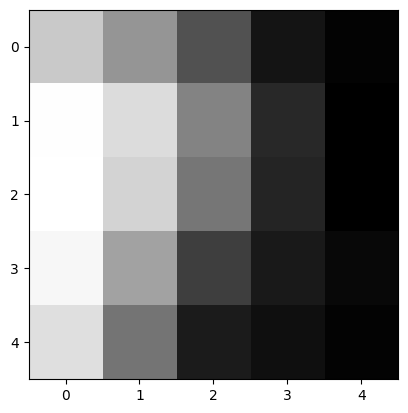

In [8]:
### Question 2
# Harris Corner Detection Algorithm

# Read the image
img_path = './cropped.png'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')

# Gaussian blur kernel
gaussian = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

# Smooth the image
image_padded = np.full((7, 7), np.average(image), dtype=np.float32)
image_padded[1:6, 1:6] = image
smooth = cv2.filter2D(image_padded, -1, gaussian)[1:6, 1:6]


# Compute gradients using Sobel operator
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
grad_x = cv2.filter2D(smooth, -1, sobel_x)
grad_y = cv2.filter2D(smooth, -1, sobel_y)


# Compute elements of the auto-correlation matrix
ixx = grad_x * grad_x
ixy = grad_x * grad_y
iyy = grad_y * grad_y

# Smooth the elements of the auto-correlation matrix
ixx_padded = np.full((7, 7), np.average(ixx), dtype=np.float32)
ixx_padded[1:6, 1:6] = ixx
ixy_padded = np.full((7, 7), np.average(ixy), dtype=np.float32)
ixy_padded[1:6, 1:6] = ixy
iyy_padded = np.full((7, 7), np.average(iyy), dtype=np.float32)
iyy_padded[1:6, 1:6] = iyy

# Gaussian blur the auto-correlation matrices
sxx = cv2.filter2D(ixx_padded, -1, gaussian)[1:6, 1:6]
sxy = cv2.filter2D(ixy_padded, -1, gaussian)[1:6, 1:6]
syy = cv2.filter2D(iyy_padded, -1, gaussian)[1:6, 1:6]

# Compute Harris corner response
R = np.zeros((5, 5), dtype=np.float32)
for i in range(5):
    for j in range(5):
        M = np.array([[sxx[i, j], sxy[i, j]],
                        [sxy[i, j], syy[i, j]]], dtype=np.float32)
        lambdas = np.linalg.eigvals(M)
        R[i, j] = (lambdas[0] * lambdas[1]) - 0.05 * ((lambdas[0] + lambdas[1]) ** 2)


 # Thresholding
R_max = np.max(R)
thresholded_corners = np.zeros_like(image)
thresholded_corners[R > 0.05 * R_max] = 1
print(thresholded_corners)

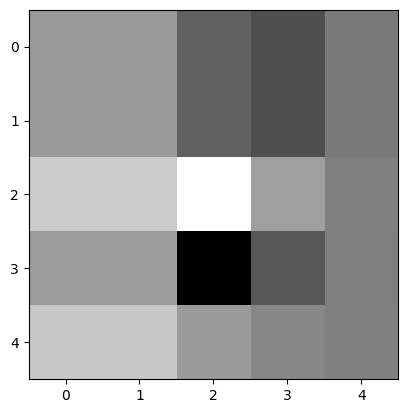

In [9]:
corner_response = cv2.cornerHarris(image, blockSize=2, ksize=3, k=0.04)
plt.imshow(corner_response, cmap = 'gray')

In [9]:
### Question 3

# Sift Implementation

# Load images
img1 = cv2.imread('image_1.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('image_2.png', cv2.IMREAD_GRAYSCALE)


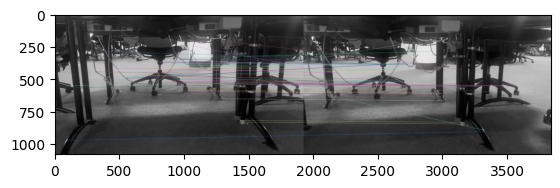

SSD value: 28220789.0
Homography matrix:
 [[ 1.12898445e+00 -1.11901606e-01 -2.04343555e+02]
 [ 3.02919274e-02  1.06703685e+00 -1.40741166e+01]
 [ 6.89979974e-05 -1.56293771e-05  1.00000000e+00]]
Inverse Homography matrix:
 [[ 8.72252809e-01  9.41044903e-02  1.79563677e+02]
 [-2.55613233e-02  9.34610268e-01  7.93052218e+00]
 [-6.05832046e-05  8.11435499e-06  9.87734415e-01]]


In [10]:
#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.figure(figsize=(10,8))
plt.imshow(img3)
plt.axis(False)
plt.title("Feature Matching")
plt.show()

ssd = 0
for match in matches:
    descriptor_1 = descriptors_1[match.queryIdx]
    descriptor_2 = descriptors_2[match.trainIdx]
    ssd += np.sum((descriptor_1 - descriptor_2) ** 2)

print("SSD value:", ssd)

# Compute Homography matrix
src_pts = np.float32([keypoints_1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

# Compute its inverse
inverse_homography = np.linalg.inv(homography)

print("Homography matrix:\n", homography)
print("Inverse Homography matrix:\n", inverse_homography)

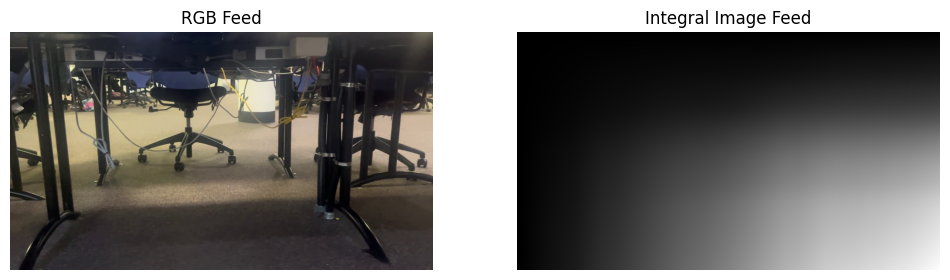

In [19]:
### Question 4

# Read the image
image = cv2.imread('image_1.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get the dimensions of the image
height, width = gray_image.shape

# Initialize integral image
integral_image = np.zeros((height, width), dtype=np.uint32)

# Compute integral image manually
for y in range(height):
    for x in range(width):
        if y == 0 and x == 0:
            integral_image[y, x] = gray_image[y, x]
        elif y == 0:
            integral_image[y, x] = integral_image[y, x - 1] + gray_image[y, x]
        elif x == 0:
            integral_image[y, x] = integral_image[y - 1, x] + gray_image[y, x]
        else:
            integral_image[y, x] = (integral_image[y - 1, x] +
                                     integral_image[y, x - 1] -
                                     integral_image[y - 1, x - 1] +
                                     gray_image[y, x])

plt.figure(figsize=(12,12))
# Display RGB feed
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('RGB Feed')
plt.axis(False)

# Normalize integral image for display
integral_image_normalized = ((integral_image - integral_image.min()) / (integral_image.max() - integral_image.min()) * 255).astype(np.uint8)

# Convert integral image to colored format for display
integral_image_colored = cv2.cvtColor(integral_image_normalized, cv2.COLOR_GRAY2BGR)

# Display integral image feed
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(integral_image_colored, cv2.COLOR_BGR2RGB))
plt.title('Integral Image Feed')
plt.axis(False)

# Show plot
plt.show()


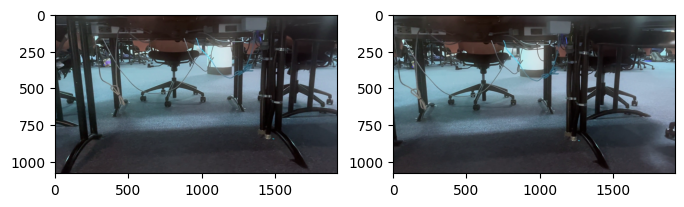

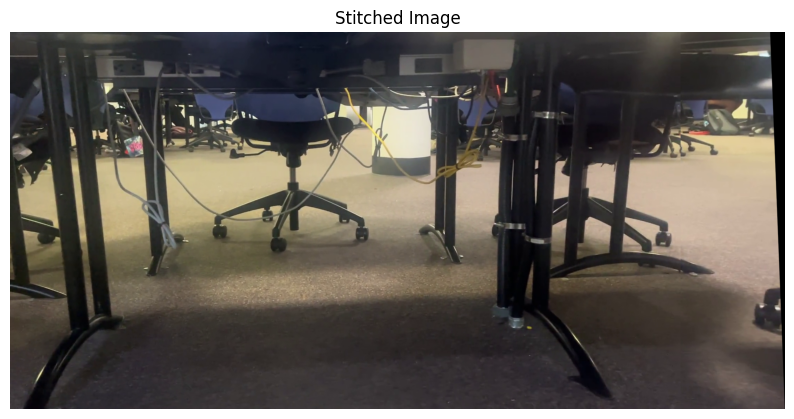

In [12]:
### Question 5

# Read the image
image1 = cv2.imread('image_1.png')
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image1)
image2 = cv2.imread('image_2.png')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.show()



def image_stitch(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Initialize feature matcher
    matcher = cv2.BFMatcher()

    # Match descriptors between the two images
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Minimum number of matches required for homography estimation
    MIN_MATCH_COUNT = 10
    if len(good_matches) < MIN_MATCH_COUNT:
        print("Insufficient matches found.")
        return None

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimate homography
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)

    # Check if homography estimation failed
    if H is None:
        print("Homography estimation failed.")
        return None

    # Warp image2 to image1 using homography
    warped_image = cv2.warpPerspective(image2, H, (image1.shape[1]+ image2.shape[1], image1.shape[0]))

    # Blend the warped image with image1
    result = warped_image.copy()
    result[:image1.shape[0], :image1.shape[1]] = image1

    # Crop black areas
    result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(result_gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    result_cropped = result[y:y+h, x:x+w]

    return result_cropped

# Read the images
image1 = cv2.imread('image_1.png')
image2 = cv2.imread('image_2.png')

# Stitch the images
stitch = image_stitch(image1, image2)

# Display the stitched image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(stitch, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.axis('off')
plt.show()





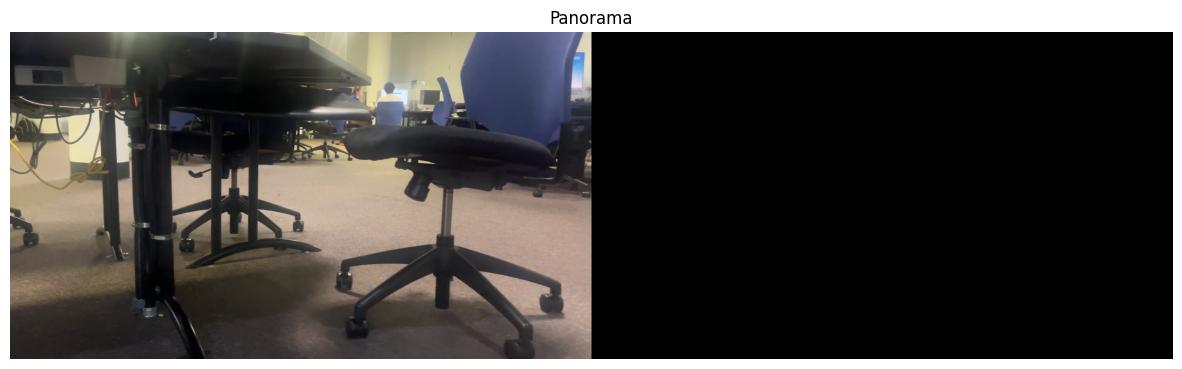

In [31]:
### Question 6

def image_stitch(image_list):
    # Convert all images to grayscale
    gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in image_list]

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    keypoints_list = []
    descriptors_list = []

    # Find keypoints and descriptors for all images
    for gray_image in gray_images:
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)

    # Initialize feature matcher
    matcher = cv2.BFMatcher()

    # Initialize list to store good matches for each pair of consecutive images
    good_matches_list = []

    # Match descriptors between all pairs of images
    for i in range(len(image_list)):
        matches_row = []
        for j in range(len(image_list)):
            if i != j:
                matches = matcher.knnMatch(descriptors_list[i], descriptors_list[j], k=2)
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)
                matches_row.append(good_matches)
            else:
                matches_row.append(None)
        good_matches_list.append(matches_row)

    # Initialize list to store homographies for each pair of consecutive images
    H_list = []

    # Estimate homographies for each pair of consecutive images
    for i in range(len(image_list)):
        H_row = []
        for j in range(len(image_list)):
            if i != j and good_matches_list[i][j] is not None:
                src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in good_matches_list[i][j]]).reshape(-1, 1, 2)
                dst_pts = np.float32([keypoints_list[j][m.trainIdx].pt for m in good_matches_list[i][j]]).reshape(-1, 1, 2)
                H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)
                H_row.append(H)
            else:
                H_row.append(None)
        H_list.append(H_row)

    # Initialize list to store warped images
    warped_images = []

    # Warp images using homographies
    for i in range(len(image_list)):
        warped_row = []
        for j in range(len(image_list)):
            if i != j and H_list[i][j] is not None:
                warped_image = cv2.warpPerspective(image_list[j], H_list[i][j], (image_list[i].shape[1] + image_list[j].shape[1], image_list[i].shape[0]))
                warped_row.append(warped_image)
            else:
                warped_row.append(None)
        warped_images.append(warped_row)

    # Initialize panorama as the first image
    panorama = image_list[0]

    # Blend warped images with the panorama
    for i in range(len(image_list)):
        for j in range(len(image_list)):
            if i != j and warped_images[i][j] is not None:
                result = warped_images[i][j].copy()
                result[:image_list[i].shape[0], :image_list[i].shape[1]] = image_list[i]
                panorama = result

    return panorama

# Assuming you have image1, image2, ..., image7 defined previously...

# Read the images
image1 = cv2.imread('image_1.png')
image2 = cv2.imread('image_2.png')
image3 = cv2.imread('image_3.png')
image4 = cv2.imread('image_4.png')
image5 = cv2.imread('image_5.png')


# Stitch the images together
panorama = image_stitch([image1, image2, image3, image4, image5])

# Display the panorama
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Panorama')
plt.axis('off')
plt.show()


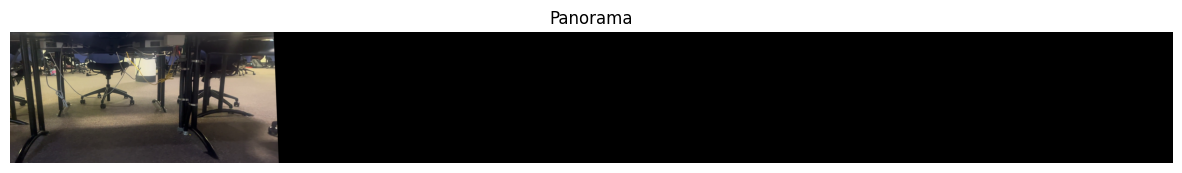

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def warp_and_blend(src_img, dst_img):
    # Convert images to grayscale
    gray_src = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    gray_dst = cv2.cvtColor(dst_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints_src, descriptors_src = sift.detectAndCompute(gray_src, None)
    keypoints_dst, descriptors_dst = sift.detectAndCompute(gray_dst, None)

    # Initialize feature matcher
    matcher = cv2.BFMatcher()

    # Match descriptors between the two images
    matches = matcher.knnMatch(descriptors_src, descriptors_dst, k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Minimum number of matches required for homography estimation
    MIN_MATCH_COUNT = 10
    if len(good_matches) < MIN_MATCH_COUNT:
        print("Insufficient matches found.")
        return None

    # Extract matched keypoints
    src_pts = np.float32([keypoints_src[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_dst[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimate homography
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)

    # Warp dst_img to src_img using homography
    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]
    warped_dst = cv2.warpPerspective(dst_img, H, (width_src + width_dst, height_src))

    # Blend the warped image with src_img
    result = warped_dst.copy()
    result[:height_src, :width_src] = src_img

    return result

def image_stitch(image_list):
    if len(image_list) < 2:
        print("Insufficient number of images for stitching.")
        return None

    # Warp and blend first two images
    panorama = warp_and_blend(image_list[0], image_list[1])

    # Warp and blend subsequent images
    for i in range(2, len(image_list)):
        panorama = warp_and_blend(panorama, image_list[i])

    return panorama

# Read the images
image1 = cv2.imread('image_1.png')
image2 = cv2.imread('image_2.png')
image3 = cv2.imread('image_3.png')
image4 = cv2.imread('image_4.png')
image5 = cv2.imread('image_5.png')


# Stitch the images together
panorama = image_stitch([image1, image2, image3, image4, image5])

# Display the panorama
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Panorama')
plt.axis('off')
plt.show()
